# Collab Write Analysis dataset

In [1]:
import pandas as pd
import itertools
from wordcloud import WordCloud

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

from word2number import w2n

nltk.download('punkt')

fill_with_r1 = False
nan_if_multilabels = True

[nltk_data] Downloading package punkt to /home/cristian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Exploration and cleaning

In [2]:
# read the data (format xlsm)
data1 = pd.read_excel('data/CollabWriteAnalysisCountCodesLadyorTigerF20nS21S22wGSAnalysis27Jan2023_14Mar2024CleanF.xlsm', sheet_name='Combined Discussions')
data2 = pd.read_excel('data/Gourley_p6.xlsx', sheet_name='Original Data')

In [3]:
# retrieve the columns
data1.columns

Index(['Course', 'Book ID', 'Topic', 'Bookclub', 'Chat0CREW1', 'Pseudonym',
       'Message', 'Message Time', 'Is Answer', 'Page', 'Response Number',
       'R1 Discussion type', 'R2DiscussionType',
       'R2DiscussionTypeInterpNothers', 'CollapsR2DiscussionTypeInterpNothers',
       'Chat0CREW1B', 'R1 Dialogic spell', 'BinaryR1DialogicSpell',
       'R1 Uptake', 'BinaryR1Uptake', 'R2DialogicSpell',
       'BinaryR2DialogicSpell', 'R2Uptake', 'BinaryR2Uptake', 'Pseudonym.1',
       'Message.1', 'Bookclub.1', 'R1 Question', 'R2 Question', 'R1 Pivot',
       'R2 Pivot', 'Memo', 'Old Code Book'],
      dtype='object')

Drop columns not needed:

In [4]:
data1 = data1[[column for column in data1.columns if not column.startswith('R1')]]
data1 = data1[[column for column in data1.columns if not column.startswith('Binary')]]

columns_to_delete = []

# Find the columns which content is equal to each other (and erase them)
for column, column2 in itertools.combinations(data1.columns, 2):
    if data1[column].equals(data1[column2]):
        columns_to_delete.append(column2)

# Delete the columns that are equal
data1.drop(columns=columns_to_delete, inplace=True)

other_columns_to_drop = ['Memo', 'Old Code Book', 'CollapsR2DiscussionTypeInterpNothers', 'R2DiscussionTypeInterpNothers']
data1.drop(columns=other_columns_to_drop, inplace=True)

# rename Book ID and Chat0CREW1 to book_id and chat_crew
columns_to_rename = {'Book ID': 'book_id', 
                     'Chat0CREW1': 'chat_crew',
                     'Bookclub': 'bookclub',
                     'Topic': 'topic',
                     'Course': 'course',
                     'Pseudonym': 'pseudonym',
                     'Message': 'message',
                     'Message Time': 'time',
                     'Is Answer': 'is_answer', 
                     'Page': 'page', 
                     'Response Number': 'response_number', 
                     'R2DiscussionType': 'discussion_type',
                     'R2DialogicSpell': 'dialogic_spell',
                     'R2Uptake': 'uptake',
                     'R2 Question': 'question',
                     'R2 Pivot': 'pivot'
                     }
data1.rename(columns=columns_to_rename, inplace=True)

In [5]:
data2.columns

Index(['Book ID', 'Topic', 'Bookclub', 'User ID', 'Name', 'Message',
       'Message Time', 'Is Answer', 'AgreementSSnMG', 'Page',
       'SS Discussion Type', 'MG Discussion Type', 'ZH Discussion Type',
       'SSnMG ', 'SSnZH ', 'ZHnMG ', 'SS'MG', 'SS'ZT', 'MG'ZH',
       'NT Discussion Type+$J$514:$J$520', 'Unnamed: 20', 'MG Uptake',
       'SS Uptake', 'ZH Uptake', 'Unnamed: 24', 'NT Uptake', 'Unnamed: 26',
       'Question', 'Pivot', 'Memo', 'SS Dialogic Spell'],
      dtype='object')

In [6]:
data2 = data2[[column for column in data2.columns if not column.startswith('Unnamed')]]

# NT columns are empty
data2 = data2[[column for column in data2.columns if not column.startswith('NT')]]

# I will choose as discussion type the one that is more voted
data2['Discussion Type'] = data2[['SS Discussion Type', 'MG Discussion Type', 'ZH Discussion Type']].mode(axis=1)[0]
data2.drop(columns=['SS Discussion Type', 'MG Discussion Type', 'ZH Discussion Type'], inplace=True)

data2['Uptake'] = data2[['SS Uptake', 'MG Uptake', 'ZH Uptake']].mode(axis=1)[0]
data2.drop(columns=['SS Uptake', 'MG Uptake', 'ZH Uptake'], inplace=True)

columns_to_drop = ['SSnMG ', 'SSnZH ', 'ZHnMG ', 'SS\'MG', 'SS\'ZT', 'MG\'ZH', 'Memo', 'AgreementSSnMG']
data2.drop(columns=columns_to_drop, inplace=True)

# transform User ID column from float to string
data2['Pseudonym'] = data2['User ID'].astype(str) + ' (' + data2['Name'] + ')'
data2.drop(columns=['User ID', 'Name'], inplace=True)

# rename Book ID and Chat0CREW1 to book_id and chat_crew
columns_to_rename = {'Book ID': 'book_id', 
                     'Bookclub': 'bookclub',
                     'Pseudonym': 'pseudonym',
                     'Topic': 'topic',
                     'Message': 'message',
                     'Message Time': 'time',
                     'Is Answer': 'is_answer', 
                     'Page': 'page', 
                     'Discussion Type': 'discussion_type',
                     'SS Dialogic Spell': 'dialogic_spell',
                     'Uptake': 'uptake',
                     'Question': 'question',
                     'Pivot': 'pivot'
                     }
data2.rename(columns=columns_to_rename, inplace=True)

In [7]:
sorted(data1.columns)

['book_id',
 'bookclub',
 'chat_crew',
 'course',
 'dialogic_spell',
 'discussion_type',
 'is_answer',
 'message',
 'page',
 'pivot',
 'pseudonym',
 'question',
 'response_number',
 'time',
 'topic',
 'uptake']

In [8]:
sorted(data2.columns)

['book_id',
 'bookclub',
 'dialogic_spell',
 'discussion_type',
 'is_answer',
 'message',
 'page',
 'pivot',
 'pseudonym',
 'question',
 'time',
 'topic',
 'uptake']

In [9]:
len(data2)

292

In [10]:
# combine data and data2
data = pd.concat([data1, data2], ignore_index=True)

#remove last 2 lines
data = data[:-2]

In [11]:
data['topic'].value_counts()

Part 1: What happens next? What is behind the door, the lady or the tiger?  Part 2: Later, the King discovers that his daughter has broken the law.  How does the King respond? What happens?                                                                                                                                                                                                               519
Using the chat discussion to the right, discuss the different arguments and “moves with evidence' the authors used in the articles. Then, as a group, craft a collaborative response to the prompt 'What are the compelling arguments for and/or against eating locally sourced food? Why are those arguments compelling?'                                                                                  288
Part 1: Discuss what would happens next and why, providing evidence or logic. What is behind the door, the lady of the tiger?  Part 2: Later, the King discovers that his daughter had broken the law, b

## Cleaning

In [12]:
# remove the first ? if present
data['course'] = data['course'].apply(lambda x: x[2:] if not pd.isna(x) and x[0] == '?' else x)

In [13]:
# if Is Answer is nan or ' ' then it is True, otherwise False
data['is_answer'] = data['is_answer'].isna() | data['is_answer'].str.isspace()

In [14]:
# bookclub always starts with Book
data['bookclub'] = data['bookclub'].fillna('').astype(str)
data = data[data['bookclub'].str.startswith('Book')]

# map Book Club One to 1, Book Club Two to 2, etc
data['bookclub'] = data['bookclub'].apply(lambda x: w2n.word_to_num(x.split(' ')[-1]))
data['bookclub'].value_counts()

1    359
4    192
2    138
3     78
7     50
5     44
6     38
Name: bookclub, dtype: int64

In [15]:
# Page number is NaN if ' ' or nan or ? 
data['page'] = data['page'].map(lambda x: pd.NA if str(x) in ['?'] or pd.isna(x) or str(x).isspace() else x)

In [16]:
# response number is 0 if ' '
data['response_number'] = data['response_number'].map(lambda x: pd.NA if str(x).isspace() or pd.isna(x) else x)

### Class cleaning

Split the sentences in the messages if they contain more than one class in column

In [17]:
def check_class(data_to_check, column, divide_also =[], take_last_of = [], change_to = pd.NA):
    new_data = data_to_check.copy()

    rows_added = 0
    rows_without_splitting = 0
    
    # I want to see if the r2_discussion_type is a list of discussion types
    rows_to_check = new_data[new_data[column].notna() & new_data[column].str.contains(',')].iterrows()

    for index, row in rows_to_check:
        types = row[column].split(',')
        n_types = len(types)

        # get sentences
        message = sent_tokenize(row['message'])
        
        # if both the parts are not empty and the number of parts is equal to the number of types
        if len(message) == n_types and all(message_part for message_part in message):
            # I have found the right split, add rows to the data and remove the old row
            data_to_insert = pd.DataFrame(columns=new_data.columns)
            data_index = index + rows_added
            for type_index, (type_, message_part) in enumerate(zip(types, message)):
                data_to_insert.loc[len(data_to_insert.index)] = row
                data_to_insert.loc[data_to_insert.index[-1], column] = type_.strip()
                data_to_insert.loc[data_to_insert.index[-1], 'message'] = message_part
                if type_index < n_types - 1:
                    for column_to_remove in take_last_of:
                        data_to_insert.loc[data_to_insert.index[-1], column_to_remove] = pd.NA
                for column_to_check in divide_also:
                    other_column = new_data.loc[data_index, column_to_check]
                    if other_column and not pd.isna(other_column):
                        other_column = str(other_column).split(',')
                        if len(other_column) == n_types:
                            data_to_insert.loc[data_to_insert.index[-1], column_to_check] = other_column[type_index].strip()
                rows_added += 1
            
            new_data = pd.concat([new_data.loc[:data_index - 1], data_to_insert, new_data.loc[data_index + 1:]]).reset_index(drop=True)
            rows_added -= 1
        else:
            # check if all the types are the same
            if len(set(types)) != 1:
                if nan_if_multilabels:
                    new_data.loc[index + rows_added, column] = change_to
                else:
                    rows_without_splitting += 1

                    # if I did not find the right split, duplicate the row and remove the multiple types
                    data_to_insert = pd.DataFrame(columns=new_data.columns)
                    data_index = index + rows_added
                    for type_index, type_ in enumerate(types):
                        data_to_insert.loc[len(data_to_insert.index)] = row
                        data_to_insert.loc[data_to_insert.index[-1], column] = type_.strip()

                        if type_index < n_types - 1:
                            for column_to_remove in take_last_of:
                                data_to_insert.loc[data_to_insert.index[-1], column_to_remove] = pd.NA

                        for column_to_check in divide_also:
                            other_column = new_data.loc[data_index, column_to_check]
                            if other_column and not pd.isna(other_column):
                                other_column = str(other_column).split(',')
                                if len(other_column) == n_types:
                                    data_to_insert.loc[data_to_insert.index[-1], column_to_check] = other_column[type_index].strip()

                        rows_added += 1

                    new_data = pd.concat([new_data.loc[:data_index - 1], data_to_insert, new_data.loc[data_index + 1:]]).reset_index(drop=True)
                    rows_added -= 1
            else:
                # remove the multiple types
                new_data.loc[index, column] = types[0].strip()
                
    return new_data

Discussion Type

In [18]:
data = check_class(data, 'discussion_type', divide_also=['question'], take_last_of=['pivot'], change_to = 'Other')

wrong_types = {'Imaginative entry' : 'Imaginative Entry',
               'Imaginative': 'Imaginative Entry'}

data['discussion_type'] = data['discussion_type'].replace(wrong_types)

# strip the values
data['discussion_type'] = data['discussion_type'].str.strip()

print(data['discussion_type'].value_counts(dropna=False))

Seminar              445
Deliberation         225
Social                79
Procedure             65
UX                    49
Imaginative Entry     29
Other                 10
Name: discussion_type, dtype: int64


/tmp/ipykernel_13465/364900255.py:37: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  new_data = pd.concat([new_data.loc[:data_index - 1], data_to_insert, new_data.loc[data_index + 1:]]).reset_index(drop=True)


Dialogic spell

In [19]:
# Page number is NaN if ' ' or nan or ? 
data['dialogic_spell'] = data['dialogic_spell'].map(lambda x: 'None' if str(x) in ['?', '\xa0'] or pd.isna(x) or str(x).isspace() else x)

# change Begin to 1 if not NA
#data['r2_dialogic_spell'] = data['r2_dialogic_spell'].map(lambda x: 1 if pd.notna(x) and x == 'Begin' else x)

#for i, row in data.iterrows():
#    if pd.notna(row['r2_dialogic_spell']) and row['r2_dialogic_spell'] in ['End', 'Break']:
#        data.at[i, 'r2_dialogic_spell'] = data.at[i - 1, 'r2_dialogic_spell']

# change everything to integers
data['dialogic_spell'] = data['dialogic_spell'].map(lambda x: int(x) if pd.notna(x) and x != 'None' else x)

print(data['dialogic_spell'].value_counts(dropna=False))

None    262
1       227
2       165
3        95
5        46
4        41
7        30
6        15
11        6
9         5
12        3
8         2
15        2
10        1
13        1
14        1
Name: dialogic_spell, dtype: int64


Uptake:

In [20]:
data['uptake'] = data['uptake'].map(lambda x: 'None' if str(x) in ['?', '\xa0'] or pd.isna(x) or str(x).isspace() else x)

print(data['uptake'].value_counts(dropna=False))

None         252
Affirm       193
Elaborate    190
Clarify      133
Filler        92
Disagree      21
Prompt        21
Name: uptake, dtype: int64


Questions

In [21]:
data = check_class(data, 'question', take_last_of=['pivot'])

right_types = ['C-HOT', 'O-HOT', 'C-LOT', 'O-LOT']

#print the rows that has values not in right_types or are nan
data[~data['question'].isin(right_types) & data['question'].notna()]


,course,book_id,topic,bookclub,chat_crew,pseudonym,message,time,is_answer,page,response_number,discussion_type,dialogic_spell,uptake,question,pivot
244,PIM P1,260,Part 1: What happens next? What is behind the ...,1,1.0,Lisa Morgan,Which questions? like the prompt?,2021-02-17 19:53:27,False,10,2.1,Deliberation,1,Clarify,O-COT,NaN
413,PIM P1,260,Part 1: What happens next? What is behind the ...,4,1.0,Michelle Rivera,I feel the flow doesn't entirely match the ori...,2021-02-23 20:40:39,False,10,2.4,Deliberation,7,Disagree,C-LOT? C-HOT?,NaN


In [22]:
# pd.NA if ' ' or nan or ?
data['question'] = data['question'].map(lambda x: 'None' if pd.isna(x) or str(x) in ['?', '\xa0'] or str(x).isspace() or '?' in str(x) or str(x) not in right_types else x)

print(data['question'].value_counts(dropna=False))

None     821
C-LOT     42
C-HOT     22
O-HOT     12
O-LOT      8
Name: question, dtype: int64


Pivot

In [23]:
# create from pivot column
data['pivot'] = data['pivot'].map(lambda x: 'None' if str(x) in ['?', '\xa0'] or pd.isna(x) or str(x).isspace() else x)

# Make not possible to have a pivot with more to
data['pivot'] = data['pivot'].map(lambda x: 'None' if pd.isna(x) or len(x.split(' to ')) > 2 else x)

data['from_pivot'] = data['pivot'].map(lambda x: pd.NA if pd.isna(x) or x == 'None' else x.split(' to ')[0].strip())
data['to_pivot'] = data['pivot'].map(lambda x: pd.NA  if pd.isna(x) or x == 'None' else x.split(' to ')[1].strip())

misspellings = {
    'Imaginative' : 'Imaginative Entry',
    'Imaginative entry' : 'Imaginative Entry',
    'Delibration' : 'Deliberation',
    'Deliberationa' : 'Deliberation',
    'Deliberation/Social/Procedure/UX' : 'Social/Procedure/UX',
    'Socal' : 'Social/Procedure/UX',
}

data['from_pivot'] = data['from_pivot'].replace(misspellings)
data['to_pivot'] = data['to_pivot'].replace(misspellings)


data['pivot'] = 'from ' + data['from_pivot'] + ' to ' + data['to_pivot']
data['pivot'] = data['pivot'].fillna('None')
print(data['pivot'].value_counts(dropna=False))

None                                               858
from Seminar to Social/Procedure/UX                 10
from Social/Procedure/UX to Seminar                  8
from Seminar to Deliberation                         7
from Deliberation to Seminar                         5
from Deliberation to Social/Procedure/UX             4
from Social/Procedure/UX to Social/Procedure/UX      4
from Seminar to Imaginative Entry                    3
from Imaginative Entry to Seminar                    3
from Social/Procedure/UX to Deliberation             3
Name: pivot, dtype: int64


In [24]:
misplaced = 0
corrected = 0

small_collaps = {
    'Imaginative Entry': 'Imaginative Entry',
    'Deliberation': 'Deliberation',
    'Social' : 'Social/Procedure/UX',
    'Procedure' : 'Social/Procedure/UX',
    'UX' : 'Social/Procedure/UX',
    'Seminar' : 'Seminar',
    'Other': 'Other'
}

for index, row in data.iterrows():
    if pd.notna(row['from_pivot']) and pd.notna(row['to_pivot']):
        current_type = row['discussion_type']

        previous_row = data.loc[index - 1]
        previous_type = previous_row['discussion_type']

        if previous_type not in small_collaps or current_type not in small_collaps:
            continue

        if row['from_pivot'] == small_collaps[previous_row['discussion_type']] and row['to_pivot'] == small_collaps[row['discussion_type']]:
            corrected += 1
        else:
            from_pivot = row['from_pivot']
            to_pivot = row['to_pivot']
            print(f'Misplaced {from_pivot} to {to_pivot}')

            guess_from_pivot = small_collaps[previous_row["discussion_type"]]
            guess_to_pivot = small_collaps[row["discussion_type"]]

            print(f'Guessed {guess_from_pivot} to {guess_to_pivot}')
            print()
            misplaced += 1

print(f'Corrected: {corrected}, Misplaced: {misplaced}')

Misplaced Seminar to Social/Procedure/UX
Guessed Seminar to Seminar

Misplaced Social/Procedure/UX to Seminar
Guessed Seminar to Social/Procedure/UX

Misplaced Social/Procedure/UX to Deliberation
Guessed Deliberation to Deliberation

Misplaced Seminar to Deliberation
Guessed Seminar to Other

Misplaced Seminar to Social/Procedure/UX
Guessed Deliberation to Seminar

Misplaced Deliberation to Seminar
Guessed Social/Procedure/UX to Seminar

Misplaced Seminar to Deliberation
Guessed Deliberation to Deliberation

Corrected: 40, Misplaced: 7


In [25]:
data.drop(columns=['from_pivot', 'to_pivot'], inplace=True)

### Save and try history

In [26]:
data.columns

Index(['course', 'book_id', 'topic', 'bookclub', 'chat_crew', 'pseudonym',
       'message', 'time', 'is_answer', 'page', 'response_number',
       'discussion_type', 'dialogic_spell', 'uptake', 'question', 'pivot'],
      dtype='object')

In [41]:
history = []
text_field = 'text'

data[text_field] = data['pseudonym'] + ': "' + data['message'] + '"'



In [42]:
data.to_csv('data/cleaned_data.csv', index=False)

## Plots

### Word cloud

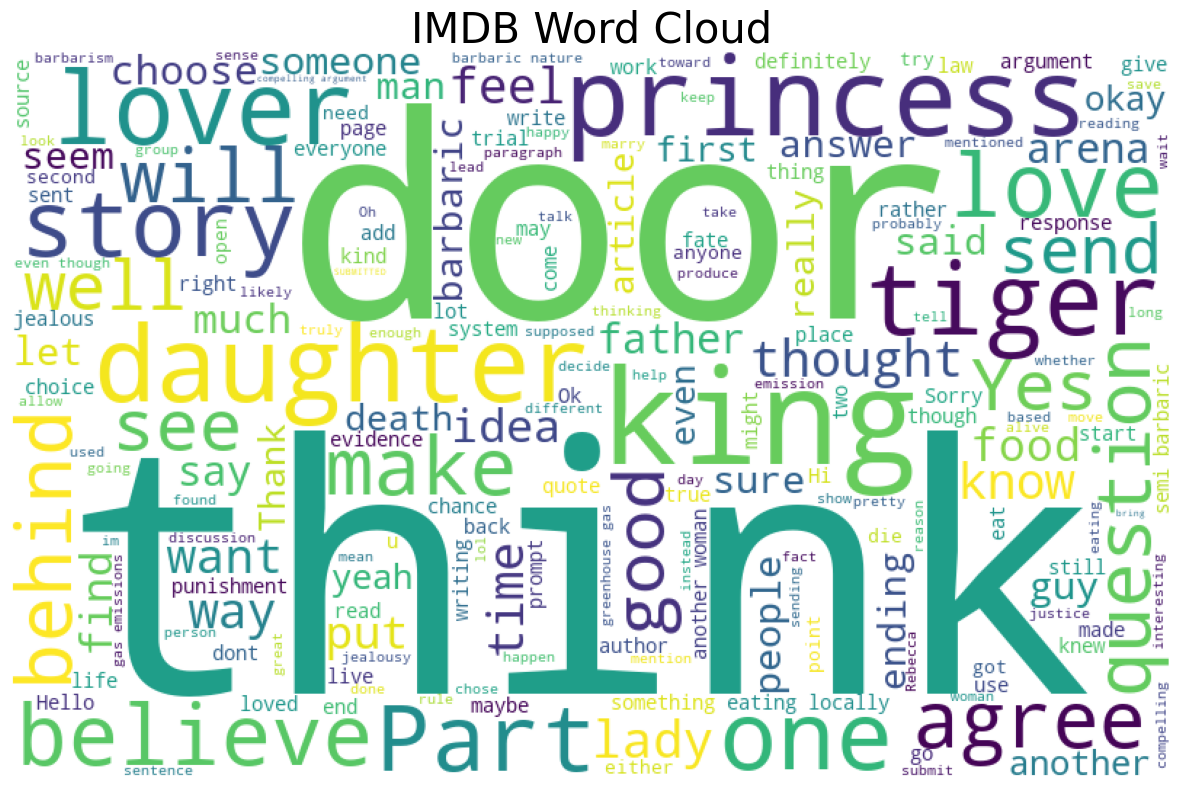

In [519]:
messages = data['message']

plt.figure(figsize=(15, 15))
wc = WordCloud(background_color='white',
               width=800,
               height=500).generate(" ".join(messages))
plt.imshow(wc)
plt.axis('off')
plt.title('IMDB Word Cloud', fontsize=30)
plt.savefig('./images/wordcloud.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [520]:
# Assuming your DataFrame is named df
message_lengths = data['message'].str.len()

# Create a histogram plot using Plotly Express
fig = px.histogram(x=message_lengths, nbins=50, labels={'x': 'Message Length', 'y': 'Frequency'})
fig.update_layout(title='Distribution of Message Lengths')
fig.show()

#Save
fig.write_image('./images/message_length_histogram.pdf', format='pdf')

In [521]:
message_counts = data['pseudonym'].value_counts()[:30]

# Create a bar chart using Plotly Express
fig = px.bar(x=message_counts.index, y=message_counts.values, labels={'x': 'Pseudonym', 'y': 'Number of Messages'})
fig.update_layout(title='Distribution of Messages per Pseudonym')
fig.show()

fig.write_image('./images/messages_per_pseudonym.pdf', format='pdf')

In [522]:
all_tokens = []
for message in data['message']:
    tokens = word_tokenize(message)
    all_tokens.extend(tokens)

# Find the longest and shortest tokens
longest_token = max(all_tokens, key=len)
shortest_token = min(all_tokens, key=len)

print("Longest Token:", longest_token)
print("Shortest Token:", shortest_token)

Longest Token: thoughts/suggestions
Shortest Token: .


In [523]:
time_data = data[['time', 'message']].copy()

# Convert the 'time' column to datetime format
time_data['time'] = pd.to_datetime(time_data['time'], errors='coerce')

time_data = time_data.dropna(subset=['time'])

# messages over date
time_data['date'] = time_data['time'].dt.date
messages_per_date = time_data.groupby('date').size().reset_index(name='count')

# Create a line plot using Plotly Express
fig = px.line(messages_per_date, x='date', y='count', labels={'date': 'Date', 'count': 'Number of Messages'})
fig.update_layout(title='Distribution of Messages Over Time')
fig.show()
fig.write_image('./images/messages_over_time.pdf', format='pdf')

# messages over hour
time_data['hour'] = time_data['time'].dt.hour
messages_per_hour = time_data.groupby('hour').size().reset_index(name='count')

# Create a bar chart using Plotly Express
fig = px.bar(messages_per_hour, x='hour', y='count', labels={'hour': 'Hour', 'count': 'Number of Messages'})
fig.update_layout(title='Distribution of Messages Over Hours')
fig.show()
fig.write_image('./images/messages_over_hour.pdf', format='pdf')

In [524]:
# Count the number of messages per book club
message_counts_by_bookclub = data['bookclub'].value_counts()

# Create a bar chart using Plotly Express
fig = px.bar(x=message_counts_by_bookclub.index, y=message_counts_by_bookclub.values, 
             labels={'x': 'Book Club', 'y': 'Number of Messages'},
             title='Distribution of Messages by Book Club')
fig.show()
fig.write_image('./images/messages_by_bookclub.pdf', format='pdf')

In [525]:
# Count the number of messages per response number
message_counts_by_response_number = data['response_number'].value_counts()

# Create a bar chart using Plotly Express
fig = px.bar(x=message_counts_by_response_number.index.astype(str), y=message_counts_by_response_number.values, 
             labels={'x': 'Response Number', 'y': 'Number of Messages'},
             title='Distribution of Messages by Response Number')
fig.show()

fig.write_image('./images/messages_by_response_number.pdf', format='pdf')

In [526]:
# Define the columns for which you want to create plots
columns_to_plot = ['discussion_type', 'dialogic_spell', 'uptake', 'question', 'pivot']

# Create plots for each category
for column in columns_to_plot:
    # Replace NaN values with 'None' for categorical columns
    data[column] = data[column].fillna('None')
    
    # Count the number of messages per category
    message_counts_by_category = data[column].value_counts()
    
    # Create a bar chart using Plotly Express
    fig = px.bar(x=message_counts_by_category.index, y=message_counts_by_category.values, 
                 labels={'x': column, 'y': 'Number of Messages'},
                 title=f'Distribution of Messages by {column}')
    fig.show()

    fig.write_image(f'./images/messages_by_{column}.pdf', format='pdf')